# Import the required modules.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns; sns.set()

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout
from keras.utils.vis_utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix

# number_of_samples determine how many samples from the attack and normal dataset should be read and used.

In [3]:
number_of_samples = 100000

# Read data from attack and normal datasets.

In [4]:
data_attack = pd.read_csv('dataset_attack.csv', nrows = number_of_samples)
data_normal = pd.read_csv('dataset_normal.csv', nrows = number_of_samples)

In [5]:
columns = [ 'frame.len', 'frame.protocols', 'ip.hdr_len',
            'ip.len', 'ip.flags.rb', 'ip.flags.df', 'p.flags.mf', 'ip.frag_offset',
            'ip.ttl', 'ip.proto', 'ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport',
            'tcp.len', 'tcp.ack', 'tcp.flags.res', 'tcp.flags.ns', 'tcp.flags.cwr',
            'tcp.flags.ecn', 'tcp.flags.urg', 'tcp.flags.ack', 'tcp.flags.push',
            'tcp.flags.reset', 'tcp.flags.syn', 'tcp.flags.fin', 'tcp.window_size',
            'tcp.time_delta','class']

data_normal.columns = columns
data_attack.columns = columns

# Drop unwanted columns

In [6]:
data_normal=data_normal.drop(['ip.src', 'ip.dst', 'frame.protocols'],axis=1)
data_attack=data_attack.drop(['ip.src', 'ip.dst', 'frame.protocols'],axis=1)

In [7]:
features = list(data_normal.columns)[:-1]
len(features)

25

In [8]:
X_normal = data_normal[features].values
X_attack = data_attack[features].values

Y_normal = data_normal['class']
Y_attack = data_attack['class']

X = np.concatenate((X_normal, X_attack))
Y = np.concatenate((Y_normal, Y_attack))

# Standardise the data

In [9]:
scalar = StandardScaler(copy=True, with_mean=True, with_std=True)
scalar.fit(X)
X = scalar.transform(X)

# the class field, replace value 'attack' with 0 and 'normal' with 1

In [10]:
for k, val in enumerate(Y.tolist()):
    Y[k] = 1.0 if val == 'attack' else 0.0

In [11]:
X = np.asarray(X).astype(np.float32)
Y = np.asarray(Y).astype(np.float32)

After feature transformation, we get a 𝑚×𝑛' matrix, where 𝑚 indicates the number of packets and 𝑛' indicates the number of new features after transformation. In order to learn patterns in both long and short term, we use a sliding window to separate continuous packets and reshape the data into a series of time windows with window size 𝑇. The label 𝑦 in each window illustrates the last packet. After reshaping, we have a three-dimensional matrix with shape (𝑚−𝑇 )×𝑇 ×𝑛'. Figure illustrates the workflow of feature extraction, transformation, and reshaping.
![dataset transformation](feature_extraction.png)
In this way, we change the features from conventional packet-based to window-based, by which we can learn network patterns from both previous (𝑇 −1) packets and current packet.

In [12]:
features = len(X[0]) # <- 25
samples = X.shape[0] # <- 10000
train_len = 25
input_len = samples - train_len # <- 99975
I = np.zeros((samples - train_len, train_len, features)) # <- np.zeros((99975, 25, 25))

for i in range(input_len):
    temp = np.zeros((train_len, features))
    for j in range(i, i + train_len - 1):
        temp[j-i] = X[j]
    I[i] = temp

In [13]:
I.shape

(199975, 25, 25)

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(I, Y[25:], test_size = 0.2)

The architecture used is 
![Model](model_brnn.png)

In [15]:
def create_baseline():
    model = Sequential()
    
    model.add(Bidirectional(LSTM(64, activation='tanh', kernel_regularizer='l2')))
    model.add(Dense(128, activation = 'relu', kernel_regularizer='l2'))
    model.add(Dense(1, activation = 'sigmoid', kernel_regularizer='l2'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
    
    return model

In [16]:
model = create_baseline()

In [17]:
X_train.dtype

dtype('float64')

In [18]:
callback = EarlyStopping(monitor='val_loss', patience=5)

In [19]:
history = model.fit(X_train, Y_train, epochs=100, validation_split=0.3, verbose=1, callbacks=[callback])

Epoch 1/100
3500/3500 [==============================] - 91s 25ms/step - loss: 0.3062 - accuracy: 0.9169 - val_loss: 0.2236 - val_accuracy: 0.9386
Epoch 2/100
3500/3500 [==============================] - 84s 24ms/step - loss: 0.2089 - accuracy: 0.9401 - val_loss: 0.1877 - val_accuracy: 0.9480
Epoch 3/100
3500/3500 [==============================] - 72s 21ms/step - loss: 0.1986 - accuracy: 0.9413 - val_loss: 0.1931 - val_accuracy: 0.9420
Epoch 4/100
3500/3500 [==============================] - 79s 23ms/step - loss: 0.1901 - accuracy: 0.9446 - val_loss: 0.1768 - val_accuracy: 0.9500
Epoch 5/100
3500/3500 [==============================] - 108s 31ms/step - loss: 0.1896 - accuracy: 0.9442 - val_loss: 0.1760 - val_accuracy: 0.9471
Epoch 6/100
3500/3500 [==============================] - 92s 26ms/step - loss: 0.1792 - accuracy: 0.9479 - val_loss: 0.1714 - val_accuracy: 0.9495
Epoch 7/100
3500/3500 [==============================] - 70s 20ms/step - loss: 0.1731 - accuracy: 0.9511 - val_loss: 

Obtained plot of accuracy

![plot of accuracy](BRNN_Model_Accuracy.png)

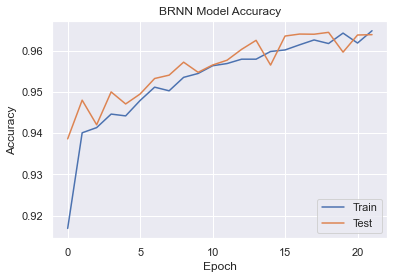

In [20]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('BRNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.savefig('BRNN Model Accuracy.png')
plt.show()

Plot of loss
![plot of loss](BRNN_Model_Loss.png)

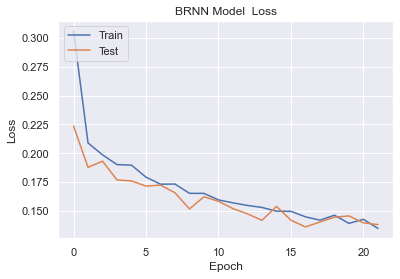

In [21]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('BRNN Model  Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('BRNN Model Loss.png')
plt.show()


In [22]:
predict = model.predict(X_test, verbose=1)

1250/1250 [==============================] - 10s 7ms/step


#  Calculate True positive,True negetive,False positive and False negetive values. Create Heatmap.

In [23]:
tp = 0
tn = 0
fp = 0
fn = 0
predictn = predict.flatten().round()
predictn = predictn.tolist()
Y_testn = Y_test.tolist()
for i in range(len(Y_testn)):
  if predictn[i]==1 and Y_testn[i]==1:
    tp+=1
  elif predictn[i]==0 and Y_testn[i]==0:
    tn+=1
  elif predictn[i]==0 and Y_testn[i]==1:
    fp+=1
  elif predictn[i]==1 and Y_testn[i]==0:
    fn+=1


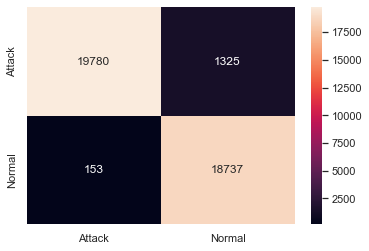

In [24]:
to_heat_map =[[tn,fp],[fn,tp]]
to_heat_map = pd.DataFrame(to_heat_map, index = ["Attack","Normal"],columns = ["Attack","Normal"])
ax = sns.heatmap(to_heat_map,annot=True, fmt="d")

# Save details 

In [25]:
figure = ax.get_figure()    
figure.savefig('confusion_matrix_BRNN.png', dpi=400)

In [31]:
import json

with open('brnn_model.json', 'w') as js:
    json.dump(model.to_json(), js, indent=4)

In [ ]:
model.save_weights("brnn_weights.h5")

In [29]:
model.save('brnn_model.h5')

In [30]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 96.30%
